*Imports*

In [56]:
#| code-fold: true

%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import dtreeviz

random_state = 621

## Methods

The end goal of making these decision trees is to model the decision making process for each coach. To help us better understand the individual trees, we will start by making an "average" baseline tree that is built using data from every coach. This classification tree will predict whether or not a coach decides to go for it on a given 4th down scenario. It may help to try this using every 4th down play, as well as with some filters imposed on the data to extract more informative, higher leverage scenarios.

## Basic Data Exploration

We will take another look at our data just so we are familiar with the parameters we are working with.

In [35]:
#| code-fold: true

df = pd.read_csv("df.csv").drop(["coach", "Unnamed: 0"], axis=1)
df = df.iloc[:,[0, 1, 2, 3, 11, 12]]
summary = pd.DataFrame({"dtypes": df.dtypes, "min" : df.min(), "mean" : df.mean(), "max" : df.max()})
print(summary)

                       dtypes  min        mean   max
game_half               int64    1    1.500789     2
half_seconds_remaining  int64    1  813.952714  1789
ydstogo                 int64    1    7.788377    46
yardline_100            int64    1   49.846885    99
score_diff              int64  -49   -1.021367    49
go                      int64    0    0.158385     1


I have only selected parameters that would be readily available simply by observing the game state at the time of decision. Essentially what this means is I am leaving out all of the win probability parameters as those result from calculations that would be hard to do on the fly, and would be difficult to interpret for our purposes, as we want to see how coaches respond to certain game situations, not how they respond to win probability situations. It is possible that they do not even look at those variables and we know for sure that they pay attention to those on-field parameters. 

In [30]:
#| code-fold: true

count_0 = sum(df["go"] == 0)
count_1 = sum(df["go"] == 1)
total = count_0 + count_1

print("Number of not go points:", count_0, count_0/total)
print("Number of go points:", count_1, count_1/total)

Number of not go points: 23476 0.8416146841614685
Number of go points: 4418 0.15838531583853158


As expected, there are far more instances of coaches not going for it than coaches going for it. 

## Baseline Model

In [ ]:
# insert code for a random classifier

## Isolate Inputs/Output

In [40]:
# Split data into features and target
X = df.drop("go", axis=1)
Y = df["go"]

# Split data into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=621)

# Check size of train and test splits
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (22315, 5)
y_train shape: (22315,)
x_test shape: (5579, 5)
y_test shape: (5579,)


## The Model
### Training

In [45]:
clf = DecisionTreeClassifier(random_state = 621, max_depth=4, min_samples_leaf=100)
model = clf.fit(x_train, y_train)

### Checking

In [50]:
#| code-fold: true

yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

def confusion_plot(y_data, y_pred):
    cm = confusion_matrix(y_data, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    print("ACCURACY: ", accuracy_score(y_data, y_pred))
    print("NEGATIVE RECALL (Y=0): ", recall_score(y_data, y_pred, pos_label=0))
    print("NEGATIVE PRECISION (Y=0): ", precision_score(y_data, y_pred, pos_label=0))
    print("POSITIVE RECALL (Y=1): ", recall_score(y_data, y_pred, pos_label=1))
    print("POSITIVE PRECISION (Y=1): ", precision_score(y_data, y_pred, pos_label=1))
    print(cm)
    disp.plot()
    plt.show()

#### Training Data

ACCURACY:  0.8858218318695107
NEGATIVE RECALL (Y=0):  0.9581814282650654
NEGATIVE PRECISION (Y=0):  0.909979633401222
POSITIVE RECALL (Y=1):  0.517467248908297
POSITIVE PRECISION (Y=1):  0.7085201793721974
[[4468  195]
 [ 442  474]]


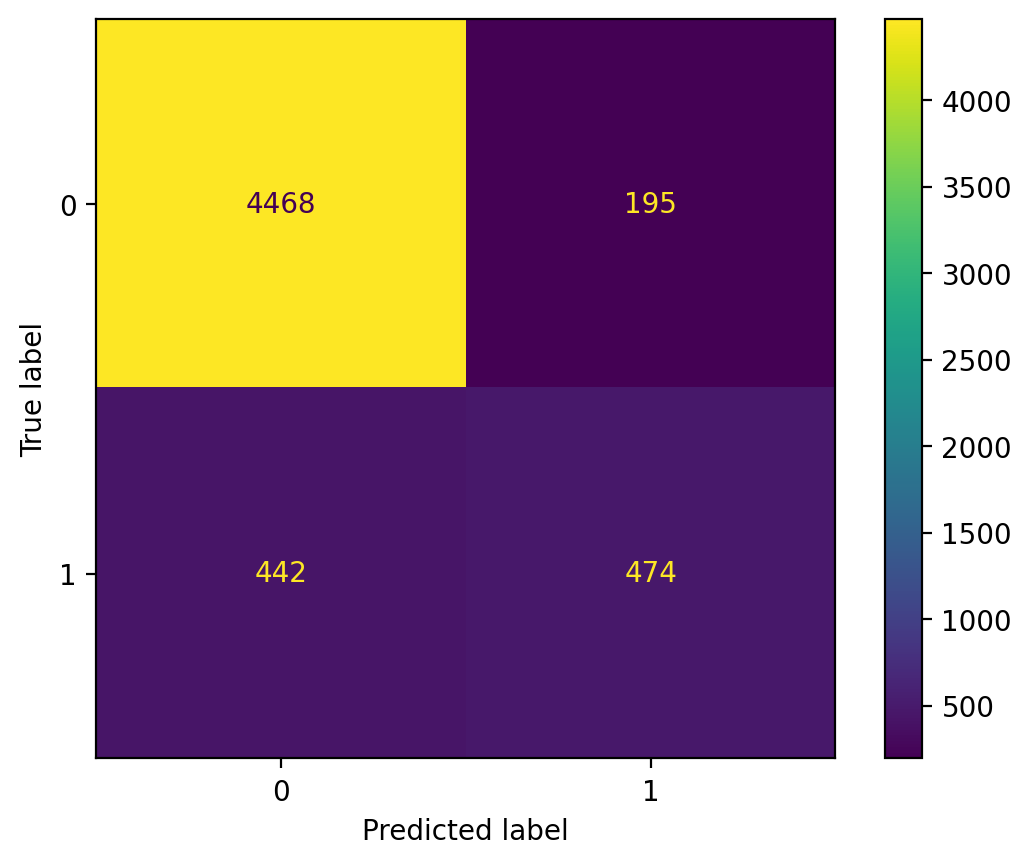

In [51]:
confusion_plot(y_test,yp_test)

#### Testing Data

ACCURACY:  0.8915079542908357
NEGATIVE RECALL (Y=0):  0.9613565087971084
NEGATIVE PRECISION (Y=0):  0.9143579373104146
POSITIVE RECALL (Y=1):  0.5162764134780126
POSITIVE PRECISION (Y=1):  0.7132149901380671
[[18086   727]
 [ 1694  1808]]


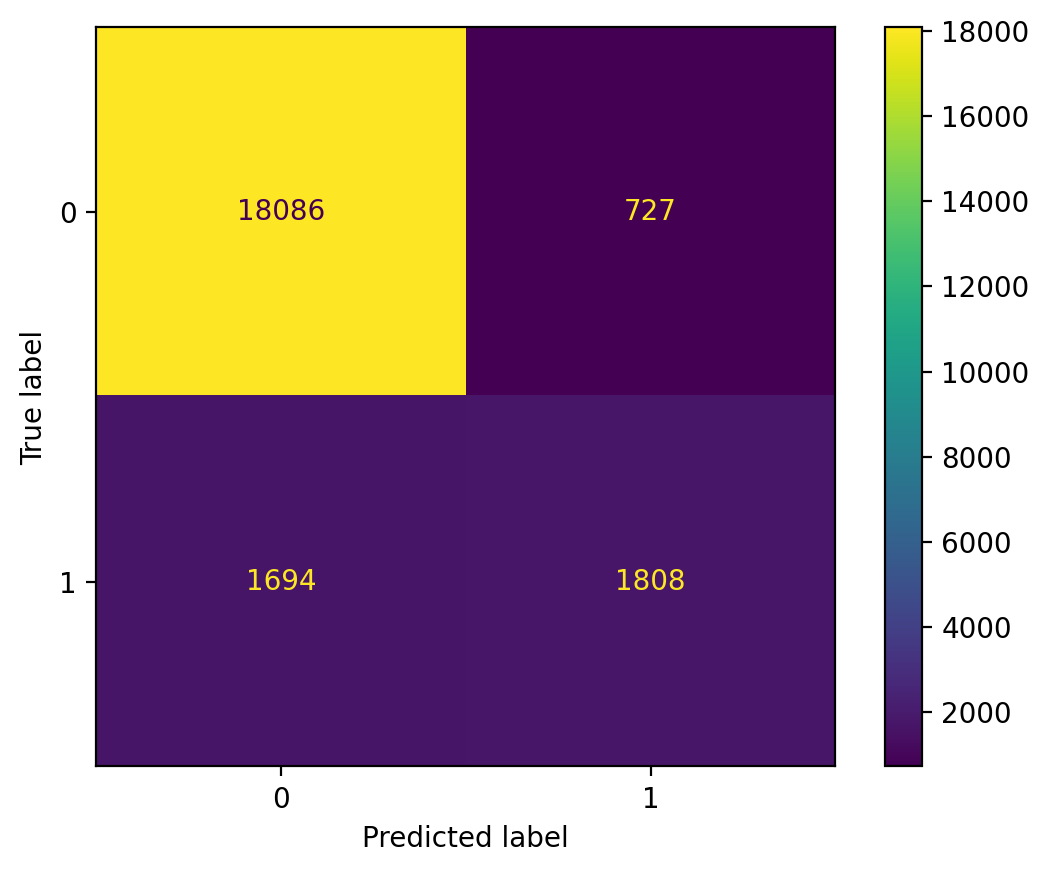

In [52]:
confusion_plot(y_train,yp_train)

Negative recall and precision are very good, meaning our model is good at predicting when coaches will not go for it, which makes sense. Positive recall and precision, on the other hand, are not nearly as good. It is much harder to predict when coaches will go for it than when they will not go for it.

### Visualize

/Users/tsigall/miniforge3/envs/r-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


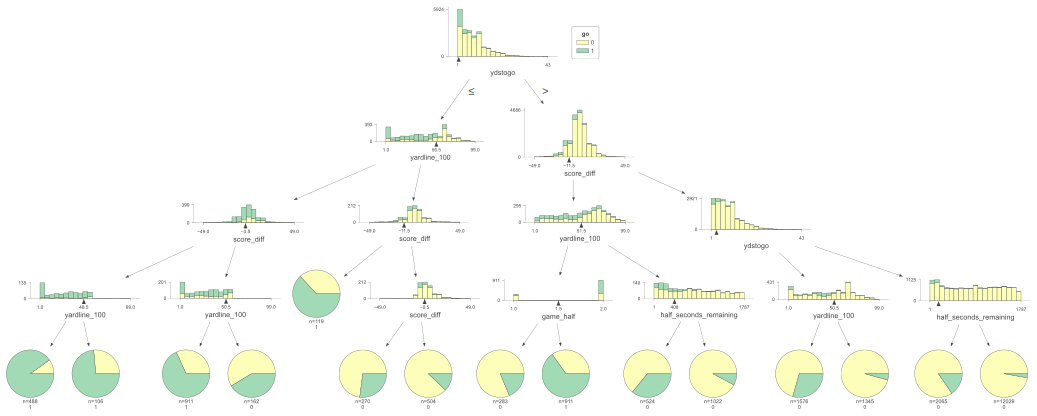

In [54]:
#| code-fold: true
#| warnings: false
viz = dtreeviz.model(clf, 
                X_train = x_train, y_train = y_train,
                target_name="go",
                feature_names=X.columns,
                class_names=[0,1])

viz.view(scale=0.8)

## Hyper-parameter Tuning

In [58]:
#| code-fold: true

# sample code from lab assignment for parameter tuning
# samples to tune: min_samples_leaf, min_samples_split, max_depth, others?

test_results=[]
train_results=[]

for num_layer in range(1,20):
    model = DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(x_train, y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([num_layer,
    accuracy_score(y_test, yp_test),
    recall_score(y_test, yp_test,pos_label=0),
    recall_score(y_test, yp_test,pos_label=1)])
    
    train_results.append([num_layer,
    accuracy_score(y_train, yp_train),
    recall_score(y_train, yp_train,pos_label=0),
    recall_score(y_train, yp_train,pos_label=1)])

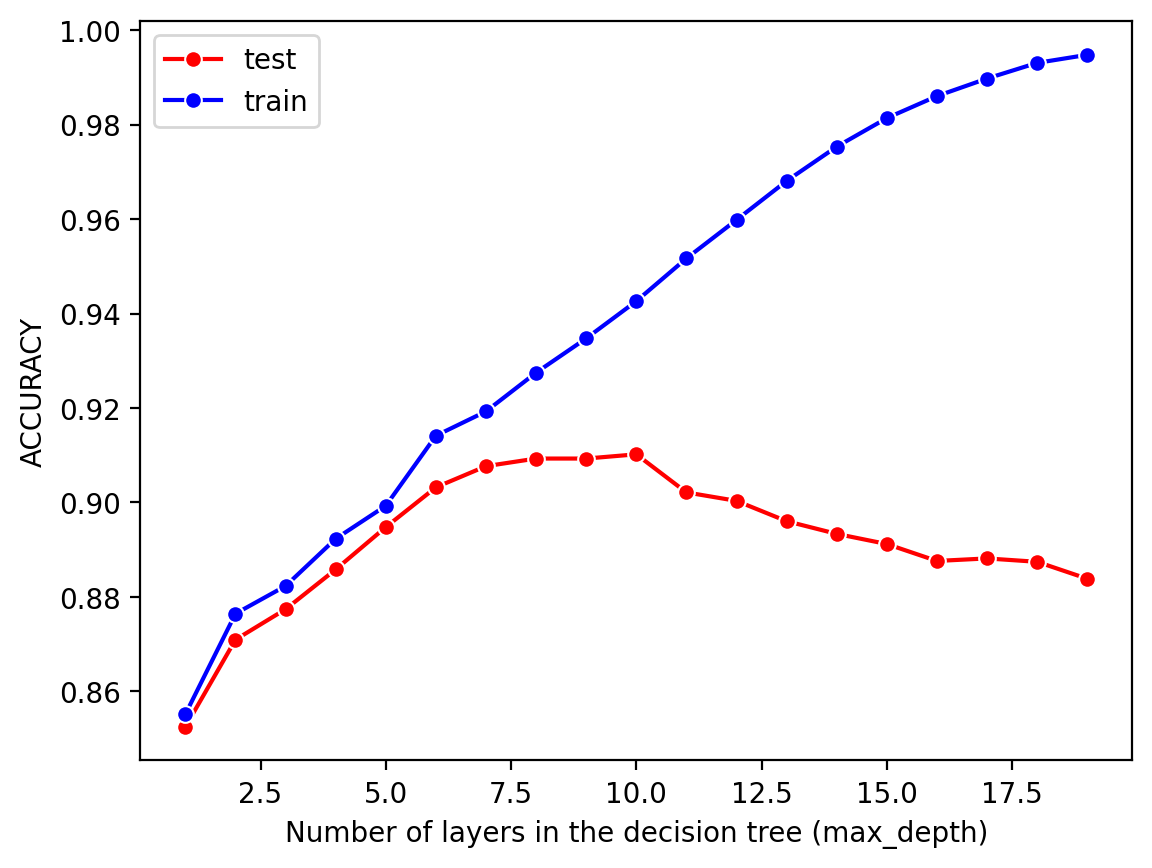

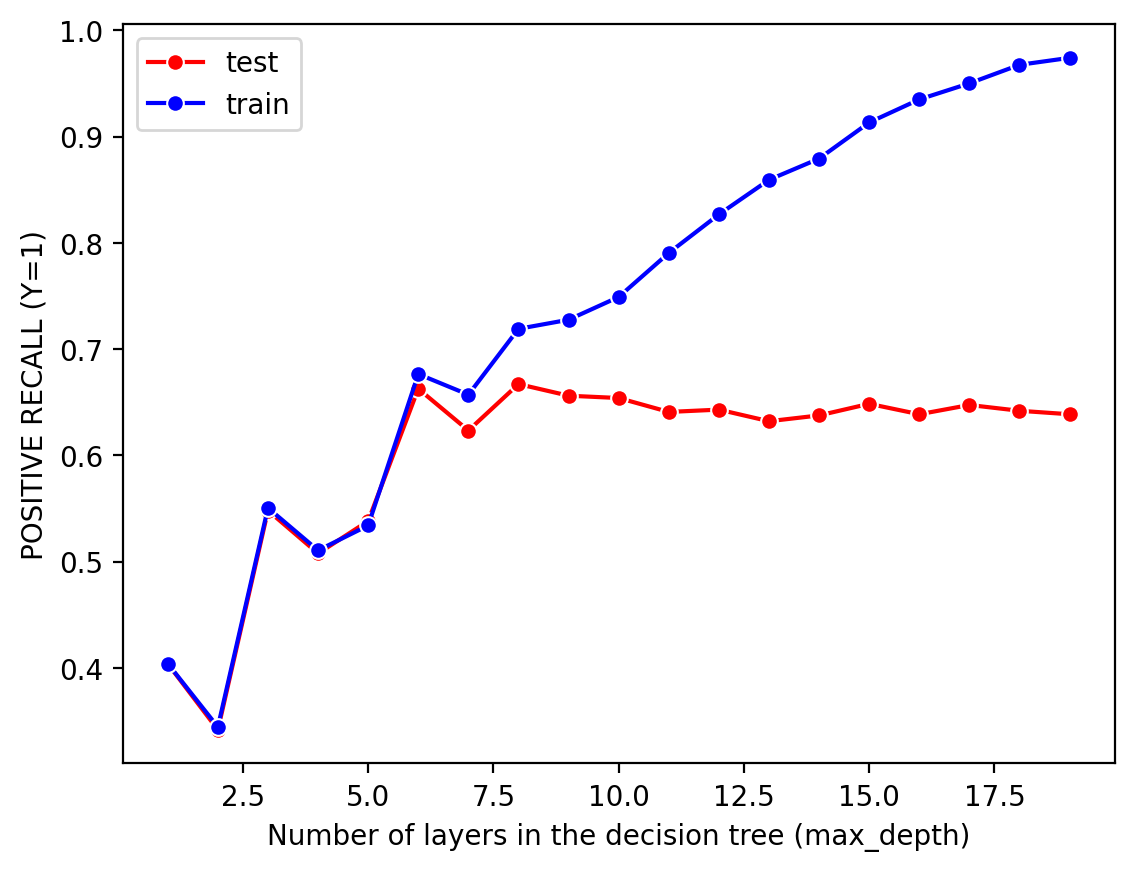

In [59]:
#| code-fold: true

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,1],
                color="red",
                marker="o",
                label="test")
sns.lineplot(x=np.asarray(train_results)[:,0],
                y=np.asarray(train_results)[:,1],
                color="blue",
                marker="o",
                label="train")
ax.set(xlabel="Number of layers in the decision tree (max_depth)", ylabel="ACCURACY")
plt.legend()
plt.show()

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,3],
                color="red",
                marker="o",
                label="test")
sns.lineplot(x=np.asarray(train_results)[:,0],
                y=np.asarray(train_results)[:,3],
                color="blue",
                marker="o",
                label="train")
ax.set(xlabel="Number of layers in the decision tree (max_depth)", ylabel="POSITIVE RECALL (Y=1)")
plt.legend()
plt.show()

8 layers appears to be the optimal `max_depth` parameter.